In [1]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.5/164.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 140.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 64.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.9/819.9 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 75.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.1/106.1 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 101.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 111.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [7]:
import cv2
import kagglehub
from ultralytics import YOLO
import os
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split

## Gather the dataset

In [8]:
# Download latest version
path = kagglehub.dataset_download("semiemptyglass/cyclist-dataset")
dataset_path = os.path.join(path, "data_tsinghua")
images_path = os.path.join(dataset_path, "images")
labels_path = os.path.join(dataset_path, "labels")

## EDA

In [41]:
# Count image and label files
image_files = os.listdir(images_path)
label_files = os.listdir(labels_path)

print(f"Number of images: {len(image_files)}")
print(f"Number of labels: {len(label_files)}")

# Check for mismatched files
missing_labels = [img for img in image_files if os.path.splitext(img)[0] + ".txt" not in label_files]
print(f"Images without labels: {len(missing_labels)}")

Number of images: 13674
Number of labels: 13674
Images without labels: 0


### Preview Annotated Image

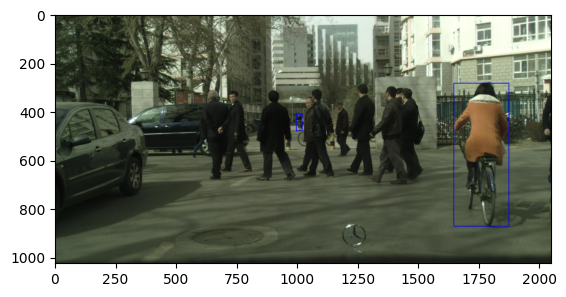

In [42]:
# Display a random image with its annotations
image_file = os.path.join(images_path, image_files[0])
label_file = os.path.join(labels_path, os.path.splitext(image_files[0])[0] + ".txt")

image = cv2.imread(image_file)
with open(label_file, "r") as f:
    annotations = f.readlines()

for ann in annotations:
    cls, x_center, y_center, width, height = map(float, ann.split())
    h, w, _ = image.shape
    x1, y1, x2, y2 = int((x_center - width / 2) * w), int((y_center - height / 2) * h), int((x_center + width / 2) * w), int((y_center + height / 2) * h)
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

### Image Data Analysis

In [43]:
# Initialize lists for image dimensions
heights = []
widths = []

# Loop through images
for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv2.imread(image_path)
    if image is not None:
        h, w, _ = image.shape
        heights.append(h)
        widths.append(w)

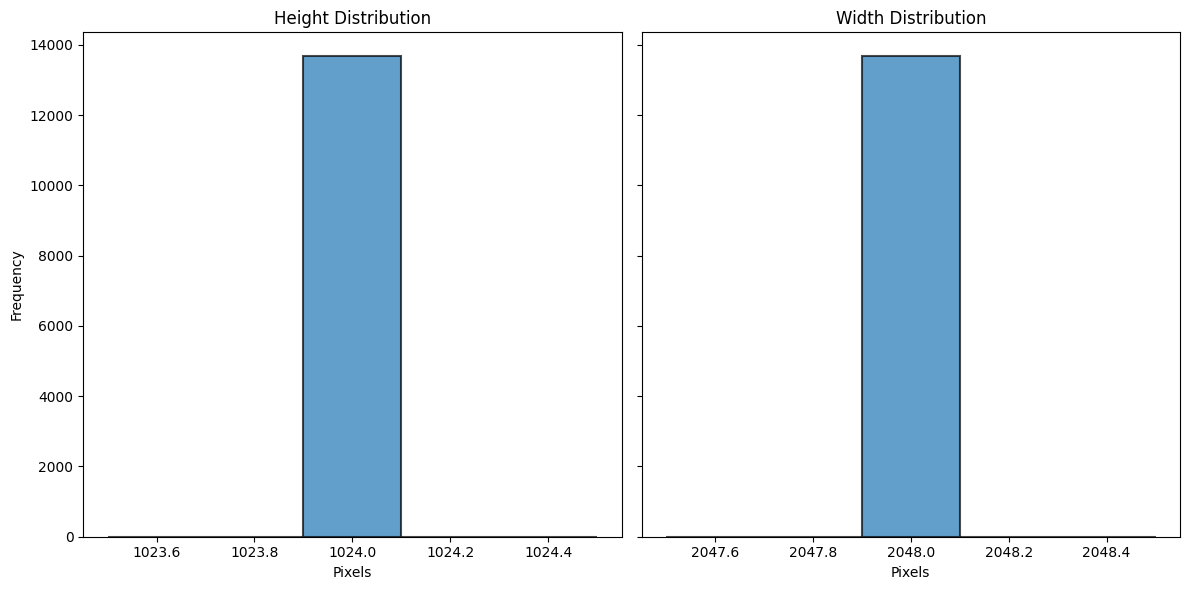

In [44]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Heights histogram
axes[0].hist(heights, bins=5, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[0].set_title("Height Distribution")
axes[0].set_xlabel("Pixels")
axes[0].set_ylabel("Frequency")

# Widths histogram
axes[1].hist(widths, bins=5, alpha=0.7, edgecolor='black', linewidth=1.5)
axes[1].set_title("Width Distribution")
axes[1].set_xlabel("Pixels")

# Adjust layout and show
plt.tight_layout()
plt.show()

### Color Profiles

In [45]:
# Count RGB and grayscale images
rgb_count = 0
grayscale_count = 0

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv2.imread(image_path)
    if image is not None:
        if len(image.shape) == 3 and image.shape[2] == 3:
            rgb_count += 1
        else:
            grayscale_count += 1

print(f"RGB images: {rgb_count}")
print(f"Grayscale images: {grayscale_count}")

RGB images: 13674
Grayscale images: 0


### EDA - Conclusion

The cyclist dataset provided contains clean data. All 13674 images have labels and have the same dimensions: `1024 x 2048`.

All images have RGB colored profile.

## Function to draw bounding boxes

In [46]:
def draw_bounding_boxes(image_path, label_path, write_image = False, filename = ''):
    # Load the image
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    height, width, _ = img.shape

    # Read YOLO labels
    with open(label_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        label = line.strip().split()
        class_id, center_x, center_y, box_width, box_height = map(float, label)

        # Convert YOLO format to OpenCV rectangle format
        x1 = int((center_x - box_width / 2) * width)
        y1 = int((center_y - box_height / 2) * height)
        x2 = int((center_x + box_width / 2) * width)
        y2 = int((center_y + box_height / 2) * height)

        # Draw rectangle on the image
        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Convert BGR image to RGB for display
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if write_image:
        cv2.imwrite(f'video_frames_with_bounding_boxes/{filename}.jpg', img_rgb)
    else:
        # Display the image with bounding boxes in Jupyter
        plt.imshow(img_rgb)
        plt.axis('off')  # Turn off axis
        plt.show()

# Example usage:
# image_path = f"{path}/data_tsinghua/images/000000.jpg"
# label_path = f"{path}/data_tsinghua/labels/000000.txt"
# draw_bounding_boxes(image_path, label_path)

## Data Preparation for Training

In [14]:
# Create output directories for splits
output_dirs = {
    "train": {"images": "/content/splits/train/images", "labels": "/content/splits/train/labels"},
    "val": {"images": "/content/splits/val/images", "labels": "/content/splits/val/labels"},
    "test": {"images": "/content/splits/test/images", "labels": "/content/splits/test/labels"},
}

for split, paths in output_dirs.items():
    os.makedirs(paths["images"], exist_ok=True)
    os.makedirs(paths["labels"], exist_ok=True)

# List all image files
image_files = [f for f in os.listdir(images_path) if f.endswith((".jpg", ".png"))]

# Split data (70% train, 20% val, 10% test)
train_files, test_files = train_test_split(image_files, test_size=0.1, random_state=42)
train_files, val_files = train_test_split(train_files, test_size=0.2, random_state=42)

# Helper function to copy images and corresponding labels
def copy_files(file_list, split_type):
    for file_name in file_list:
        # Copy image
        shutil.copy(
            os.path.join(images_path, file_name),
            os.path.join(output_dirs[split_type]["images"], file_name),
        )
        # Copy label (ensure label file exists)
        label_file = file_name.replace(".jpg", ".txt").replace(".png", ".txt")
        if os.path.exists(os.path.join(labels_path, label_file)):
            shutil.copy(
                os.path.join(labels_path, label_file),
                os.path.join(output_dirs[split_type]["labels"], label_file),
            )

# Copy files into respective directories
copy_files(train_files, "train")
copy_files(val_files, "val")
copy_files(test_files, "test")

#  Verify the dataset structure
print("Dataset split completed:")
for split, paths in output_dirs.items():
    print(f"{split} -> Images: {len(os.listdir(paths['images']))}, Labels: {len(os.listdir(paths['labels']))}")

Dataset split completed:
train -> Images: 9844, Labels: 9844
val -> Images: 2462, Labels: 2462
test -> Images: 1368, Labels: 1368


## Code to create the model

In [15]:
# Creatint a config to train the model
data_yaml = """
train: /content/splits/train
val: /content/splits/val
test: /content/splits/test

nc: 1
names: ['cyclist']
"""

yaml_path = os.path.join("/content", "cyclist_dataset.yaml")
with open(yaml_path, "w") as f:
    f.write(data_yaml)

print(f"YAML configuration saved to: {yaml_path}")

YAML configuration saved to: /content/cyclist_dataset.yaml


In [16]:
# Train YOLOv8 model
model = YOLO("yolov8n.pt")

model.train(
    data=yaml_path,
    epochs=50,
    imgsz=1280,
    batch=32,
    workers=8,
    device=0,
    save=True,
    save_period=5
)

100%|██████████| 6.25M/6.25M [00:00<00:00, 372MB/s]

New https://pypi.org/project/ultralytics/8.3.47 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/cyclist_dataset.yaml, epochs=50, time=None, patience=100, batch=32, imgsz=1280, save=True, save_period=5, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False,

100%|██████████| 755k/755k [00:00<00:00, 129MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 362MB/s]


AMP: checks passed ✅


train: Scanning /content/splits/train/labels... 9844 images, 1219 backgrounds, 0 corrupt: 100%|██████████| 9844/9844 [00:07<00:00, 1253.05it/s]


train: New cache created: /content/splits/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /content/splits/val/labels... 2462 images, 266 backgrounds, 0 corrupt: 100%|██████████| 2462/2462 [00:02<00:00, 1119.86it/s]


val: New cache created: /content/splits/val/labels.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        17G     0.8962      2.157     0.9165         53       1280: 100%|██████████| 308/308 [01:51<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:12<00:00,  3.12it/s]


                   all       2462       3980      0.838      0.764      0.848      0.656

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      16.6G     0.8728      0.902      0.921         70       1280: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.54it/s]


                   all       2462       3980      0.873      0.795      0.882      0.705

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      16.4G     0.8482     0.7613     0.9167         54       1280: 100%|██████████| 308/308 [01:48<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]

                   all       2462       3980      0.851      0.816      0.876      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      16.6G     0.8367      0.718     0.9116         56       1280: 100%|██████████| 308/308 [01:48<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.51it/s]


                   all       2462       3980      0.877      0.824      0.897      0.703

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      16.4G     0.8007     0.6649     0.9001         63       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.39it/s]


                   all       2462       3980      0.887       0.84      0.911      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      16.6G     0.7689     0.6296     0.8909         79       1280: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.45it/s]

                   all       2462       3980      0.907      0.849      0.922      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      16.6G     0.7442     0.6014     0.8833         49       1280: 100%|██████████| 308/308 [01:48<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]

                   all       2462       3980      0.903      0.856       0.93      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      16.5G     0.7311     0.5813      0.879         69       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]

                   all       2462       3980      0.908      0.855      0.925      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      16.5G     0.7178     0.5686     0.8765         69       1280: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.61it/s]

                   all       2462       3980      0.908      0.877      0.937      0.784



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      16.5G     0.7038     0.5469     0.8702         68       1280: 100%|██████████| 308/308 [01:47<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.32it/s]

                   all       2462       3980      0.905      0.879      0.934      0.781



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      16.5G     0.6955     0.5396     0.8671         72       1280: 100%|██████████| 308/308 [01:48<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.60it/s]


                   all       2462       3980      0.917      0.872      0.941      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      16.4G     0.6812     0.5203     0.8638         84       1280: 100%|██████████| 308/308 [01:48<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.55it/s]


                   all       2462       3980      0.922      0.867      0.942        0.8

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      16.4G     0.6722     0.5127     0.8615         61       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.38it/s]


                   all       2462       3980      0.918      0.891       0.95      0.801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      16.4G     0.6705     0.5025     0.8601         63       1280: 100%|██████████| 308/308 [01:49<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.51it/s]

                   all       2462       3980      0.915      0.889      0.947      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      16.5G     0.6587     0.4897     0.8577         72       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]

                   all       2462       3980      0.911      0.891      0.946      0.808



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      16.5G     0.6494     0.4846     0.8569         68       1280: 100%|██████████| 308/308 [01:49<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.47it/s]


                   all       2462       3980      0.911      0.893      0.949      0.817

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      16.6G     0.6427     0.4719      0.852         76       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.47it/s]


                   all       2462       3980      0.934      0.892      0.957      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      16.4G     0.6362     0.4644     0.8534         59       1280: 100%|██████████| 308/308 [01:49<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.66it/s]


                   all       2462       3980      0.925      0.894      0.953      0.819

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      16.6G     0.6286     0.4548     0.8502         60       1280: 100%|██████████| 308/308 [01:48<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.44it/s]

                   all       2462       3980      0.918      0.908      0.957      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      16.5G      0.627     0.4507     0.8498         43       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.40it/s]

                   all       2462       3980       0.93      0.902       0.96      0.827



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      16.4G     0.6201     0.4441     0.8478         81       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


                   all       2462       3980      0.936      0.899      0.963      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      16.4G      0.619     0.4393     0.8498         73       1280: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.58it/s]


                   all       2462       3980      0.934      0.906      0.964      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      16.5G     0.6098     0.4319     0.8451         68       1280: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.49it/s]


                   all       2462       3980      0.931      0.909      0.964      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      16.6G     0.6004     0.4226     0.8425         52       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.29it/s]


                   all       2462       3980      0.932      0.912      0.965       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      16.6G     0.6011     0.4232     0.8424         47       1280: 100%|██████████| 308/308 [01:47<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]

                   all       2462       3980      0.935      0.906      0.964      0.841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      16.5G     0.5955     0.4149     0.8414         55       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.46it/s]


                   all       2462       3980      0.931      0.916      0.967      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      16.6G     0.5877      0.407     0.8414         43       1280: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.51it/s]


                   all       2462       3980      0.939       0.92      0.968      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      16.4G     0.5786     0.3981     0.8376         99       1280: 100%|██████████| 308/308 [01:47<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.55it/s]


                   all       2462       3980       0.94      0.917      0.968       0.85

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      16.6G     0.5883     0.4008     0.8374         57       1280: 100%|██████████| 308/308 [01:49<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.35it/s]

                   all       2462       3980      0.934      0.922       0.97      0.854



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      16.5G     0.5789      0.393     0.8383         57       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]


                   all       2462       3980      0.944       0.92      0.969      0.856

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      16.4G     0.5733     0.3918     0.8358         43       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.46it/s]

                   all       2462       3980      0.939      0.923      0.971      0.855



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      16.6G     0.5642     0.3807     0.8334         77       1280: 100%|██████████| 308/308 [01:48<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.47it/s]

                   all       2462       3980      0.937      0.925      0.971      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      16.4G     0.5604     0.3777      0.836         49       1280: 100%|██████████| 308/308 [01:48<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]

                   all       2462       3980      0.946      0.923      0.971      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      16.6G     0.5556     0.3719     0.8327         73       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.52it/s]

                   all       2462       3980      0.946      0.933      0.974      0.861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      16.7G     0.5534     0.3673     0.8334         60       1280: 100%|██████████| 308/308 [01:49<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.54it/s]

                   all       2462       3980      0.938      0.941      0.973      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      16.5G     0.5471     0.3606     0.8299         48       1280: 100%|██████████| 308/308 [01:49<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.53it/s]


                   all       2462       3980      0.945      0.926      0.973      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      16.5G      0.545     0.3575     0.8303         42       1280: 100%|██████████| 308/308 [01:48<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.61it/s]


                   all       2462       3980      0.944      0.927      0.974      0.864

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      16.6G     0.5435     0.3563     0.8278         87       1280: 100%|██████████| 308/308 [01:49<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.49it/s]


                   all       2462       3980      0.947       0.93      0.974      0.866

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      16.5G     0.5358     0.3491      0.829         67       1280: 100%|██████████| 308/308 [01:47<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.36it/s]

                   all       2462       3980      0.939      0.939      0.974      0.867



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      16.5G     0.5301     0.3444     0.8281         66       1280: 100%|██████████| 308/308 [01:47<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.37it/s]


                   all       2462       3980      0.947      0.927      0.973      0.868
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      16.5G     0.5033      0.317     0.8088         23       1280: 100%|██████████| 308/308 [01:47<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.69it/s]

                   all       2462       3980      0.945      0.928      0.973       0.86



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      16.4G     0.4943     0.3035     0.8084         28       1280: 100%|██████████| 308/308 [01:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.67it/s]

                   all       2462       3980      0.949       0.93      0.973      0.865



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      16.4G     0.4887      0.301     0.8064         26       1280: 100%|██████████| 308/308 [01:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.64it/s]


                   all       2462       3980      0.958      0.927      0.974      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      16.4G     0.4837     0.2948     0.8067         33       1280: 100%|██████████| 308/308 [01:42<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.63it/s]

                   all       2462       3980      0.958      0.928      0.976      0.871



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      16.3G     0.4802     0.2909     0.8043         36       1280: 100%|██████████| 308/308 [01:44<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.72it/s]

                   all       2462       3980      0.954      0.934      0.975       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      16.4G     0.4765     0.2855     0.8045         50       1280: 100%|██████████| 308/308 [01:44<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.61it/s]


                   all       2462       3980      0.956      0.929      0.976      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      16.4G     0.4705     0.2816     0.8033         37       1280: 100%|██████████| 308/308 [01:43<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:11<00:00,  3.43it/s]


                   all       2462       3980      0.952      0.935      0.975      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      16.4G     0.4633     0.2764     0.8012         23       1280: 100%|██████████| 308/308 [01:43<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.66it/s]


                   all       2462       3980      0.956       0.93      0.976      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      16.6G     0.4609     0.2734     0.8003         31       1280: 100%|██████████| 308/308 [01:45<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.81it/s]

                   all       2462       3980      0.951      0.937      0.975      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      16.3G     0.4589     0.2698        0.8         32       1280: 100%|██████████| 308/308 [01:45<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:10<00:00,  3.71it/s]

                   all       2462       3980      0.951      0.936      0.975      0.874



50 epochs completed in 1.667 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.3MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:12<00:00,  3.14it/s]


                   all       2462       3980      0.951      0.936      0.976      0.874
Speed: 0.2ms preprocess, 0.8ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c72a430b430>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [59]:
# Using best weights
best_weights_path = os.path.join("/content/runs/detect/train/weights/best.pt")
model = YOLO(best_weights_path)

## Model Evaluation

In [60]:
# Evaluate the model on the test set
results = model.val(data=yaml_path, split="test")

Ultralytics 8.3.39 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/splits/test/labels.cache... 1368 images, 138 backgrounds, 0 corrupt: 100%|██████████| 1368/1368 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 86/86 [00:08<00:00,  9.67it/s]


                   all       1368       2343      0.958      0.941      0.979      0.883
Speed: 0.3ms preprocess, 1.3ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/val


In [61]:
# Print overall evaluation metrics
print("Overall Test Metrics:")
print(f"Precision: {results.box.p[0]}") # Access precision using results.box.p[0]
print(f"Recall: {results.box.r[0]}")    # Access recall using results.box.r[0]
print(f"mAP@0.5: {results.maps[0]}")      # Access mAP@0.5 using results.maps[0]

# Check if results.maps has more than one element before accessing index 1
if len(results.maps) > 1:
    print(f"mAP@0.5:0.95: {results.maps[1]}")  # Access mAP@0.5:0.95 using results.maps[1]
else:
    print("mAP@0.5:0.95: Not available")  # Handle the case where mAP@0.5:0.95 is not calculated

Overall Test Metrics:
Precision: 0.9578595658453999
Recall: 0.9410274520094075
mAP@0.5: 0.8829606445522306
mAP@0.5:0.95: Not available


### Visualize Predictions

In [62]:
# Visualize predictions on test set
predictions = model.predict(
    source="/content/splits/test/images",  # Path to test images
    save=True,                            # Save predictions to runs directory
    imgsz=1280,                           # Image size
    conf=0.25                             # Confidence threshold for predictions
)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1368 /content/splits/test/images/000006.jpg: 640x1280 2 cyclists, 10.4ms
image 2/1368 /content/splits/test/images/000014.jpg: 640x1280 2 cyclists, 7.1ms
image 3/1368 /content/splits/test/images/000045.jpg: 640x1280 1 cyclist, 7.4ms
image 4/1368 /content/splits/test/images/000057.jpg: 640x1280 1 cyclist, 7.2ms
image 5/1368 /content/splits/test/images/000093.jpg: 640x1280 1 cyclist, 7.2ms
image 6/1368 /content/splits/test/images/000103.jpg: 640x1

## Model Evaluation - Conclusion


### Evaluation Results
Precision: **95.79%**
Indicates the proportion of correctly predicted cyclist objects out of all predictions. The model minimizes false positives effectively.

Recall: **94.10%**
Indicates the proportion of actual cyclist objects correctly detected by the model. The model achieves a high detection rate.

mAP@0.5: **88.30%**
Reflects the model's performance across all predicted bounding boxes at an IoU threshold of 0.5. Indicates strong detection capabilities.

#### Overall Assessment
The model demonstrated excellent detection accuracy with high precision and recall.
The high mAP@0.5 score confirms that the model is highly effective in localizing and classifying cyclists at a standard IoU threshold.

## Visualized Results

## Function to create labels from an image

In [63]:
# Generate Labels for image
def create_labels(image_path, model, output_label_path):
    results = model(image_path)
    img = cv2.imread(image_path)
    height, width, _ = img.shape

    with open(output_label_path, 'w') as label_file:
        for detection in results[0].boxes:
            class_id = int(detection.cls)
            x1, y1, x2, y2 = detection.xyxy.cpu().numpy().flatten()
            box_width = (x2 - x1) / width
            box_height = (y2 - y1) / height
            center_x = (x1 + x2) / (2 * width)
            center_y = (y1 + y2) / (2 * height)
            label_file.write(f"{class_id} {center_x} {center_y} {box_width} {box_height}\n")

## Usage


image 1/1 /content/testing/seattle.jpg: 864x1280 1 cyclist, 11.0ms
Speed: 8.4ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 864, 1280)
Results saved to runs/detect/predict

image 1/1 /content/testing/seattle.jpg: 864x1280 1 cyclist, 7.5ms
Speed: 6.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 864, 1280)


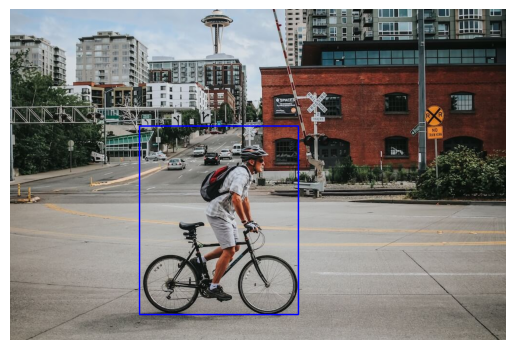

In [64]:
# Testing on an image
image_file = 'seattle'
test_image_path = os.path.join("/content/testing", f"{image_file}.jpg")
results = model(test_image_path, save=True)

output_label_path = os.path.join("testing", f"{image_file}.txt")
create_labels(test_image_path, model, output_label_path)
draw_bounding_boxes(test_image_path, output_label_path)

## Convert the video into individual images saved to video_frames dir

In [65]:
def video_to_frames(video_path, output_dir):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    os.makedirs(output_dir, exist_ok=True)

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_name = f"frame_{frame_count:04d}.png"
        frame_path = os.path.join(output_dir, frame_name)
        cv2.imwrite(frame_path, frame)
        frame_count += 1

    cap.release()
    print(f"Extracted {frame_count} frames to {output_dir}")

# Example usage
video_path = os.path.join("testing", f"bikerVideo.mp4")
output_dir = "video_frames"
video_to_frames(video_path, output_dir)

Extracted 498 frames to video_frames


## Create label files and images with bounding boxes

In [66]:
video_frame_directory = "video_frames"
output_label_directory = "video_frames_labels"
os.makedirs(output_label_directory, exist_ok=True)

for frame_file in os.listdir(video_frame_directory):
    frame_path = os.path.join(video_frame_directory, frame_file)
    output_label_path = os.path.join(output_label_directory, f"{os.path.splitext(frame_file)[0]}.txt")

    create_labels(frame_path, model, output_label_path)
    draw_bounding_boxes(frame_path, output_label_path, write_image=True, filename=frame_file)


image 1/1 /content/video_frames/frame_0203.png: 736x1280 1 cyclist, 9.6ms
Speed: 5.1ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/video_frames/frame_0108.png: 736x1280 1 cyclist, 7.5ms
Speed: 4.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/video_frames/frame_0234.png: 736x1280 1 cyclist, 7.1ms
Speed: 4.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/video_frames/frame_0410.png: 736x1280 (no detections), 6.9ms
Speed: 4.6ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/video_frames/frame_0216.png: 736x1280 1 cyclist, 6.9ms
Speed: 4.6ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 736, 1280)

image 1/1 /content/video_frames/frame_0274.png: 736x1280 1 cyclist, 8.0ms
Speed: 4.7ms preprocess, 8.0ms inference, 1.6ms postprocess

___

PDF export and other utils below

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [70]:
import shutil

# Define source and destination paths
source_folder = "/content/runs"
destination_folder = "/content/drive/MyDrive/colab-runs"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy the folder and its contents
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'/content/drive/MyDrive/colab-runs'

In [27]:
# Define source and destination paths for the 'splits' folder
source_splits_folder = "/content/splits"
destination_splits_folder = "/content/drive/MyDrive/colab-splits"
# Create the destination folder if it doesn't exist
os.makedirs(destination_splits_folder, exist_ok=True)

# Copy the 'splits' folder and its contents
shutil.copytree(source_splits_folder, destination_splits_folder, dirs_exist_ok=True)

'/content/drive/MyDrive/colab-splits'

In [71]:
destination_folder = "/content/drive/MyDrive/colab_521"

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Copy video_frames and video_frames_labels
source_frames_folder = "/content/video_frames"
shutil.copytree(source_frames_folder, destination_folder, dirs_exist_ok=True)

source_labels_folder = "/content/video_frames_labels"
shutil.copytree(source_labels_folder, destination_folder, dirs_exist_ok=True)


'/content/drive/MyDrive/colab_521'

In [56]:
import locale

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding
!apt-get update

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,626 kB]
Get:12 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [32.9 kB]
Get:13 http://a

In [57]:
!apt-get install texlive-xetex texlive-fonts-recommended texlive-latex-extra pandoc inkscape

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  aspell aspell-en dictionaries-common dvisvgm enchant-2 fig2dev fonts-droid-fallback fonts-lato
  fonts-lmodern fonts-noto-mono fonts-texgyre fonts-urw-base35 gawk ghostscript glib-networking
  glib-networking-common glib-networking-services gsettings-desktop-schemas gsfonts hunspell-en-us
  imagemagick imagemagick-6-common imagemagick-6.q16 lib2geom1.1.0 libapache-pom-java libaspell15
  libatkmm-1.6-1v5 libcairomm-1.0-1v5 libcdr-0.1-1 libcmark-gfm-extensions0.29.0.gfm.3
  libcmark-gfm0.29.0.gfm.3 libcommons-logging-java libcommons-parent-java libdbus-glib-1-2
  libdjvulibre-text libdjvulibre21 libenchant-2-2 libfftw3-double3 libfontbox-java libfontenc1
  libglibmm-2.4-1v5 libgs9 libgs9-common libgsl27 libgslcblas0 libgspell-1-2 libgspell-1-common
  libgtkmm-3.0-1v5 libhunspell-1.7-0 libidn12 libijs-0.35 libimage-magick-perl
  libimage-m

In [72]:
!jupyter nbconvert --to pdf '/content/main.ipynb'

[NbConvertApp] Converting notebook /content/main.ipynb to pdf
/usr/local/share/jupyter/nbconvert/templates/latex/display_priority.j2:32: UserWarning: Your element with mimetype(s) dict_keys(['application/vnd.colab-display-data+json']) is not able to be represented.
  ((*- endblock -*))
[NbConvertApp] Support files will be in main_files/
[NbConvertApp] Making directory ./main_files
[NbConvertApp] Writing 494445 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 726060 bytes to /content/main.pdf
